# README

### 1. DYNAMIC ALLOCATION MODEL SPX-TREASURIES USING C-MEAN FORECAST OF ROLLING REGRESSIONS (EXPANDING WINDOW): SHORT TERM FORECASTING
#### 1.1 GOAL
- Construct a short term trading model that switches in steps on a monthly basis between S&P500 and Treasuries using a forecasted return for next month. The forecasted return for next month is based on a combined forecast of univariate expanding window regressions of monthly excess returns on several predictors.

- feb 2023 update: unfinished as oos r-squared seem too strange. Haven't found code error/data error yet. If you do, please let me know

variables. Back-test the model on monthly data.
#### 1.2 PROCESS

Response/dependent variable/endog/target variable: 
    - monthly excess returns (S&P500 return - Treasury return) transformed to monthly log returns
- Regressors/independent variables/features/exogs/predictors:
    - market variables: momentum 1m, momentum 3m, momentum 1m, momentum 1m, distance to 1m moving average of the excess returns.
    - seasonality: monthly dummies, presidential cycle?
    - monetary variables: 10-2 term spread,pce deflator, real Fed rate, real 10y yield, real Tbill rate, Baa yield spread
    - monetary variables shocks: 1-month changes in the monetary variables
    - macro variables:  1m change in LEI, ISM_index, 1m change in USA OECD amplitude adjusted, 1m change in consumer sentiment,

- Collect data from csv_file that contains all necessary data (response and predictors). Clean and initial conversions:
    - Create correct **raw time_series formats**: dropna(), set_index, Datetime index with correct frequency, resampled to end of month so that all variables will have aligned dates to concat later on. Squeeze df to series, check for correct data-types, check data-formats <br> 
    (percentage in decimals,...), name the index and the value of the series, check shape and plot. <br>
    - Create a **lagged time_series** if necessary for macroeconomic predictors that are published in a period with reference to a lagged period. <br> 
    Make the series **point-in-time**.<br>
    - Create **log_return series** from simple return series: (np.log(1+R) = np.log1p(R)). <br>
<br>
- Construct and display **descriptive statistics** for all variables (response and predictors, simple returns and log returns). Plot them.

- Test for a trend-stationary process on the raw data (but on log returns). <br>
- Create time_series of z-_scores and trim them to remove outliers to min/max = -3/+3:
    - The z-scores make the time_series easily comparable (also after regression to compare strength of beta effects visually) with <br> the same scale.Create 2 sorts of z_scores per predictor: <br>
        - in_sample_z_scores: z_scores will be used for in-sample predictive regression on the full dataset. <br> 
        - In-sample z-scores create look-ahead bias but regression already creates look-ahead bias. <br>
                For in-sample testing hence, ok. <br>
         - out_of_sample_z_scores: time_series of z-_scores per predictor calculated recursively (expanding window: with a warm-up period and then calculated from start till the next value). The out_of_sample_z_scores will be used for out-of-sample predictive regressions. <br>

- Test for a trend-stationary process on the transformed data. Drop any series that is still stationary for future testing. <br>

- perform OLS in-sample: in-sample means perform univariate ols-regression using the full dataset.

for each variable: <br>

- Run a predictive in-sample regression on the lagged variables (z-scores, 1-month lagged)<br>

$$ r_{t} = C + \beta x_{t-1}+\epsilon_{t} $$

$$ r_{t} = \text{log excess return of month t}  $$
$$ x_{t-1} = \text{predictor value previous month t-1 = predictor lagged 1 month}  $$
$$ C_{t} = \text{Intercept coefficient estimated in sample}  $$
$$ \beta_{t} = \text{beta coefficient estimated in sample}  $$

for each variable and for each time step t: <br>

- Run a predictive expanding regression on the lagged variables (expanding z_scores of the variables, warmed up n = 60 months) with a warm-up of n = 60 months of the form:<br>

$$ r_{t} = C_{t} + \beta_{t}x_{t-1}+\epsilon_{t} $$

$$ r_{t} = \text{log excess return of month t}  $$
$$ x_{t-1} = \text{predictor value previous month t-1 = predictor lagged 1 month}  $$
$$ C_{t} = \text{Constant coefficient estimated at month t}  $$
$$ \beta_{t} = \text{beta coefficient estimated at month t}  $$

- Each month - and for each predictor - we have estimated coefficients at month t that used all data from the warm-up date until month t. In contrast to in-sample predictive regressions our coefficients are now time-varying and are updated as new information becomes available. Expanding window regressions do not contain look-ahead bias as they only use information that was available for the investor at time t. Out z-scores are also adjusted for look-ahead bias as they are calculated on an expanding window as well. The downside of all this is that we have lost about 10 years of data (warm-up expanding z-score is 60 months and then we use a warm-up of 60 months again to warm-up our predictive regression)

- Since we have estimated coefficients for each month - and for each variable - we can now use the regression results and forecast the log excess return of next month (forecast for t+1 at month t) per predictor. Our forecast is:

$$ \hat r_{t+1} = \hat C_{t} + \hat \beta_{t}x_{t} $$


- Calculate the Campbell and Thompson out-of-sample R-squared statistic for each predictor and for the C-mean:
Project unfinished here!



- built 3 models with signals and weights:
    - binary_model: binary signals: if z-score < 0: invest 100% in treasuries, else 100% S&P500.
    - dynamic_model: weights equal to the percentile of the z-score (2y warm-up)
    - dynamic_step_model: weights equal to the percentile of the z-score but then adjusted to only transact when 10% weight barriers are crossed.
- backtest the 3 models against a static 50/50 portfolio (50% spx and 50% treasuries)

#### 1.3 MOTIVATION
- I publish my work and learning process because of the protégé effect.
- Teaching and/or explaining a process to others is the best way to learn for myself.
#### 1.4 INTENDED USE
- This notebook is for illustrative and education purposes only. Feel free to use this code for these purposes.
- The logic and/or python code might contain errors.All mistakes remain the author's fault. If you find any, let me know so I can rectify.
#### 1.5 LIMITATIONS & FUTURE CHALLENGES
- Lasso, Ridge regression
- other variables
#### 1.6 CREDITS
- This code uses my own package called my_risk_kit.py for certain functions. 
- The idea for the trading model - to use the mean of univariate forecasts instead of multivariate forecasts - came from the interesting paper below:

Rapach, David and Zhou, Guofu, Asset Pricing: Time-Series Predictability (March 24, 2022). Oxford Research Encyclopedia of Economics and Finance, Available at SSRN: https://ssrn.com/abstract=3941499 or http://dx.doi.org/10.2139/ssrn.3941499



In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

import yfinance as yf

import my_risk_kit as mrk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [531]:
# Import csv file with all us data

us_data = pd.read_csv('us_data.csv',header=0)
us_data.head()

,date,us_equity,date.1,us_treasury,date.2,yield10y,date.3,yield2y,date.4,yield3m,date.5,cpi,date.6,cpi_index,date.7,core_cpi,date.8,core_cpi_index,date.9,core_pce,date.10,core_pce_index,date.11,fed_funds,date.12,baa_yield,date.13,lei_yoy,date.14,ism_comp,date.15,ism_serv,date.16,ism_serv_new,date.17,ism_manu,date.18,ism_manu_new,date.19,oecd_us,date.20,oecd_global,date.21,oecd_japan,date.22,cons_conf_exp,date.23,jobless_claims_4w,date.24,parttime_work,date.25,sp500,date.26,div_yield,date.27,price_to_book,date.28,price_to_cashflow,date.29,price_earnings,date.30,cape
0,12/31/1969,100.000,1/31/1973,98.99,1/31/1962,4.102,6/30/1976,7.02,2/29/1960,4.19,1/31/1960,1.0,1/31/1960,29.37,1/31/1960,2.0,1/31/1960,30.5,1/31/1960,2.06736,1/31/1960,17.033,1/29/1971,4.0,1/1/1919,7.12,1/31/1960,6.2,12/31/1997,55.3,7/31/1997,56.7,7/31/1997,58.8,1/31/1960,61.5,1/31/1960,65.4,1/31/1960,100.7828,6/30/1961,101.0219,1/31/1960,100.6939,2/28/1975,50.0,1/31/1967,209.00,1/31/1960,2507.0,2/29/1960,56.12,12/31/1970,3.3966,4/28/1995,2.6446,4/28/1995,7.2996,4/28/1995,15.7323,9/30/1994,15.66
1,1/30/1970,92.798,2/28/1973,98.73,2/28/1962,4.002,7/30/1976,6.74,3/31/1960,3.02,2/29/1960,1.7,2/29/1960,29.41,2/29/1960,2.3,2/29/1960,30.6,2/29/1960,2.17951,2/29/1960,17.065,2/26/1971,3.5,2/1/1919,7.20,2/29/1960,4.6,1/31/1998,56.5,8/31/1997,62.0,8/31/1997,60.2,2/29/1960,52.3,2/29/1960,52.5,2/29/1960,100.4750,7/31/1961,101.1119,2/29/1960,100.7284,5/31/1975,69.8,2/28/1967,229.00,2/29/1960,2565.0,3/31/1960,55.34,1/29/1971,3.2541,5/31/1995,2.7417,5/31/1995,7.9602,5/31/1995,16.3315,10/31/1994,16.06
2,2/27/1970,97.949,3/30/1973,98.73,3/30/1962,3.862,8/31/1976,6.50,4/29/1960,3.04,3/31/1960,1.7,3/31/1960,29.41,3/31/1960,2.0,3/31/1960,30.6,3/31/1960,2.08146,3/31/1960,17.067,3/31/1971,5.5,3/1/1919,7.15,3/31/1960,2.2,2/28/1998,55.7,9/30/1997,56.2,9/30/1997,59.3,3/31/1960,47.8,3/31/1960,52.2,3/31/1960,100.1341,8/31/1961,101.1520,3/31/1960,100.7213,8/31/1975,70.7,3/31/1967,248.00,3/31/1960,2405.0,4/29/1960,54.37,2/26/1971,3.2145,6/30/1995,2.8020,6/30/1995,8.1248,6/30/1995,16.7154,11/30/1994,15.51
3,3/31/1970,98.458,4/30/1973,99.66,4/30/1962,3.862,9/30/1976,6.33,5/31/1960,3.12,4/30/1960,1.7,4/30/1960,29.54,4/30/1960,2.0,4/30/1960,30.6,4/30/1960,2.00454,4/30/1960,17.098,4/30/1971,5.5,4/1/1919,7.23,4/30/1960,2.6,3/31/1998,54.4,10/31/1997,56.6,10/31/1997,60.8,4/30/1960,45.3,4/30/1960,52.0,4/30/1960,99.8119,9/30/1961,101.1476,4/30/1960,100.6903,11/30/1975,69.9,4/28/1967,264.00,4/30/1960,2769.0,5/31/1960,55.83,3/31/1971,3.0904,7/31/1995,2.8987,7/31/1995,8.4347,7/31/1995,17.3294,12/30/1994,15.70
4,4/30/1970,89.865,5/31/1973,99.88,5/31/1962,3.902,10/29/1976,6.03,6/30/1960,2.19,5/31/1960,1.7,5/31/1960,29.57,5/31/1960,1.7,5/31/1960,30.6,5/31/1960,2.03777,5/31/1960,17.125,5/31/1971,5.5,5/1/1919,7.09,5/31/1960,1.9,4/30/1998,54.5,11/30/1997,58.5,11/30/1997,59.9,5/31/1960,42.6,5/31/1960,45.8,5/31/1960,99.5305,10/31/1961,101.1120,5/31/1960,100.6669,2/29/1976,81.2,5/31/1967,235.75,5/31/1960,2733.0,6/30/1960,56.92,4/30/1971,2.9726,8/31/1995,2.7662,8/31/1995,7.9093,8/31/1995,16.0190,1/31/1995,15.35


### Create raw, correct time_series from data_source. Plus: point-in-time + log returns

In [532]:
# Raw Time-series for benchmarks and response variables: price series and simple + log returns

# equity prices (total return-)
equity_prices_tr = us_data[['date','us_equity']]
equity_prices_tr.dropna(inplace = True)
equity_prices_tr.set_index('date',inplace = True)
equity_prices_tr.index = pd.to_datetime(equity_prices_tr.index)
equity_prices_tr = equity_prices_tr.resample('M').last()
equity_prices_tr = equity_prices_tr.squeeze()
equity_prices_tr.index.name = 'date'
equity_prices_tr.name = 'equity_prices_tr'

# treasury prices (total return)
treasury_prices_tr = us_data[['date.1','us_treasury']]
treasury_prices_tr.dropna(inplace = True)
treasury_prices_tr.set_index('date.1',inplace = True)
treasury_prices_tr.index = pd.to_datetime(treasury_prices_tr.index)
treasury_prices_tr = treasury_prices_tr.resample('M').last()
treasury_prices_tr = treasury_prices_tr.squeeze()
treasury_prices_tr.index.name = 'date'
treasury_prices_tr.name = 'treasury_prices_tr'

# nominal 3m tbill yield series: used for risk-free rate, sharpes,...
yield_3m = us_data[['date.4','yield3m']]
yield_3m.dropna(inplace = True)
yield_3m.set_index('date.4',inplace = True)
yield_3m.index = pd.to_datetime(yield_3m.index)
yield_3m = yield_3m.resample('M').last()
yield_3m = yield_3m.squeeze()
yield_3m = yield_3m / 100
yield_3m.name = 'yield_3m'
yield_3m.index.name = 'date'

# nominal 3m tbill monthly returns, log returns and prices total return series. No need to resample as yield_3m is resampled.
tbill_returns_1m = yield_3m / 12
log_tbill_returns_1m = np.log1p(tbill_returns_1m) # np.log1p(x) = np.log(1+x)
log_tbill_returns_1m.name = 'log_tbill_returns_1m'

tbill_prices_tr = (1 + tbill_returns_1m).cumprod()
tbill_prices_tr.name = 'tbill_prices_tr'

# equity monthly returns: simple and log. No need to resample as equity_prices_tr is resampled.
equity_returns_1m = (equity_prices_tr / equity_prices_tr.shift(1) - 1).dropna()
equity_returns_1m.name ='equity_returns_1m'
log_equity_returns_1m = np.log1p(equity_returns_1m) # np.log1p(x) = np.log(1+x)
log_equity_returns_1m.name = 'log_equity_returns_1m'

# treasury monthly returns: simple and log. No need to resample as treasury_prices_tr is resampled.
treasury_returns_1m = (treasury_prices_tr / treasury_prices_tr.shift(1) - 1).dropna()
treasury_returns_1m.name ='treasury_returns_1m'
log_treasury_returns_1m = np.log1p(treasury_returns_1m) # np.log1p(x) = np.log(1+x)
log_treasury_returns_1m.name = 'log_treasury_returns_1m'

# excess monthly returns: simple and log.  No need to resample as source variables are resampled.
excess_returns_1m = (equity_returns_1m - treasury_returns_1m).dropna()
excess_returns_1m.name ='excess_returns_1m'
log_excess_returns_1m = np.log1p(excess_returns_1m)
log_excess_returns_1m.name = 'log_excess_returns_1m'

# excess monthly returns: simple and log. No need to resample as source variables are resampled.
balanced_returns_1m = (0.5*treasury_returns_1m + 0.5*equity_returns_1m).dropna()
balanced_returns_1m.name = 'balanced_returns_1m'
log_balanced_returns_1m = np.log1p(balanced_returns_1m)
log_balanced_returns_1m.name = 'log_balanced_returns_1m'

In [533]:
# Raw time-series of predictors: shift if needed for point-in-time, simple returns and log returns for momentum measures
# Transformed time-series pf predictors: but first descriptive statistics in next cell plus test for a trend-stationary process in the raw time-series
# Transformed series: difference (absolute, percentage, order) and/or trimmed normalized (full, rolling or expanding) and/or np.log(), np.sqrt(). 
# After test for stationarity! Then retest stationary again on transformed time_series.

# Momentum features
mom_1m = excess_returns_1m.dropna()
mom_1m = mom_1m.resample('M').last()
mom_1m_log = np.log1p(mom_1m) #transform in equivalen log return
mom_1m_log.name = 'mom_1m_log'

mom_1m_log_z = stats.zscore(mom_1m_log)
mom_1m_log_z = mrk.trim_z_scores(mom_1m_log_z)
mom_1m_log_z.name = 'mom_1m_log_z'
mom_1m_log_z_exp = mrk.expanding_z_score(mom_1m_log,warmup=60).dropna()
mom_1m_log_z_exp = mrk.trim_z_scores(mom_1m_log_z_exp)
mom_1m_log_z_exp.name = 'mom_1m_log_z_exp'

mom_3m = mrk.mom_score(excess_returns_1m,per=3).dropna()
mom_3m = mom_3m.resample('M').last()
mom_3m_log = np.log1p(mom_3m) #transform in equivalen log return
mom_3m_log.name = 'mom_3m_log'

mom_3m_log_z = stats.zscore(mom_3m_log)
mom_3m_log_z = mrk.trim_z_scores(mom_3m_log_z)
mom_3m_log_z.name = 'mom_3m_log_z'
mom_3m_log_z_exp = mrk.expanding_z_score(mom_3m_log,warmup=60).dropna()
mom_3m_log_z_exp = mrk.trim_z_scores(mom_3m_log_z_exp)
mom_3m_log_z_exp.name = 'mom_3m_log_z_exp'

mom_6m = mrk.mom_score(excess_returns_1m,per=6).dropna()
mom_6m = mom_6m.resample('M').last()
mom_6m_log = np.log1p(mom_6m) #transform in equivalen log return
mom_6m_log.name = 'mom_6m_log'

mom_6m_log_z = stats.zscore(mom_6m_log)
mom_6m_log_z = mrk.trim_z_scores(mom_6m_log_z)
mom_6m_log_z.name = 'mom_6m_log_z'
mom_6m_log_z_exp = mrk.expanding_z_score(mom_6m_log,warmup=60).dropna()
mom_6m_log_z_exp = mrk.trim_z_scores(mom_6m_log_z_exp)
mom_6m_log_z_exp.name = 'mom_6m_log_z_exp'

mom_12m = mrk.mom_score(excess_returns_1m,per=12).dropna()
mom_12m = mom_12m.resample('M').last()
mom_12m_log = np.log1p(mom_12m) #transform in equivalen log return
mom_12m_log.name = 'mom_12m_log'

mom_12m_log_z = stats.zscore(mom_12m_log)
mom_12m_log_z = mrk.trim_z_scores(mom_12m_log_z)
mom_12m_log_z.name = 'mom_12m_log_z'
mom_12m_log_z_exp = mrk.expanding_z_score(mom_12m_log,warmup=60).dropna()
mom_12m_log_z_exp = mrk.trim_z_scores(mom_12m_log_z_exp)
mom_12m_log_z_exp.name = 'mom_12m_log_z_exp'

In [534]:
# Raw time-series of predictors: shift if needed for point-in-time, simple returns and log returns for momentum measures
# Transformed time-series of predictors: but first descriptive statistics in next cell plus test for a trend-stationary process in the raw time-series
# Transformed series: difference (absolute, percentage, order) and/or trimmed normalized (full, rolling or expanding) and/or np.log(), np.sqrt(). 
# After test for stationarity! Then retest stationary again on transformed time_series.

# nominal 10y yield series
yield_10y = us_data[['date.2','yield10y']]
yield_10y.dropna(inplace = True)
yield_10y.set_index('date.2',inplace = True)
yield_10y.index = pd.to_datetime(yield_10y.index)
yield_10y = yield_10y.squeeze()
yield_10y = yield_10y / 100
yield_10y.name='yield_10y'
yield_10y.index.name='date'
yield_10y = yield_10y.resample('M').last()

yield_10y_z = stats.zscore(yield_10y)
yield_10y_z = mrk.trim_z_scores(yield_10y_z)
yield_10y_z.name='yield_10y_z'
yield_10y_z_exp = mrk.expanding_z_score(yield_10y,warmup=60).dropna()
yield_10y_z_exp = mrk.trim_z_scores(yield_10y_z_exp)
yield_10y_z_exp.name='yield_10y_z_exp'

# nominal 3m yield series
yield_3m_z = stats.zscore(yield_3m)
yield_3m_z = mrk.trim_z_scores(yield_3m_z)
yield_3m_z.name='yield_3m_z'
yield_3m_z_exp = mrk.expanding_z_score(yield_3m,warmup=60).dropna()
yield_3m_z_exp = mrk.trim_z_scores(yield_3m_z_exp)
yield_3m_z_exp.name='yield_3m_z_exp'

# the 10y-3m term spread
term_spread_10y3m = (yield_10y - yield_3m).dropna()
term_spread_10y3m.name = 'term_spread_10y3m'

term_spread_10y3m_z = stats.zscore(term_spread_10y3m)
term_spread_10y3m_z = mrk.trim_z_scores(term_spread_10y3m_z)
term_spread_10y3m_z.name='term_spread_10y3m_z'
term_spread_10y3m_z_exp = mrk.expanding_z_score(term_spread_10y3m,warmup=60).dropna()
term_spread_10y3m_z_exp = mrk.trim_z_scores(term_spread_10y3m_z_exp)
term_spread_10y3m_z_exp.name='term_spread_10y3m_z_exp'

# Nominal Baa yield
yield_Baa = us_data[['date.12','baa_yield']]
yield_Baa.dropna(inplace = True)
yield_Baa.set_index('date.12',inplace = True)
yield_Baa.index = pd.to_datetime(yield_Baa.index)
yield_Baa = yield_Baa.squeeze()
yield_Baa = yield_Baa / 100
yield_Baa.name = 'yield_Baa'
yield_Baa.index.name = 'date'
yield_Baa = yield_Baa.resample('M').last()

yield_Baa_z = stats.zscore(yield_Baa)
yield_Baa_z = mrk.trim_z_scores(yield_Baa_z)
yield_Baa_z.name='yield_Baa_z'
yield_Baa_z_exp = mrk.expanding_z_score(yield_Baa,warmup=60).dropna()
yield_Baa_z_exp = mrk.trim_z_scores(yield_Baa_z_exp)
yield_Baa_z_exp.name='yield_Baa_z_exp'

# nominal pce deflator yoy series
core_pce = us_data[['date.9','core_pce']]
core_pce.dropna(inplace = True)
core_pce.set_index('date.9',inplace = True)
core_pce.index = pd.to_datetime(core_pce.index)
core_pce = core_pce.squeeze()
core_pce = core_pce / 100
core_pce.name = 'core_pce'
core_pce.index.name = 'date'
core_pce = core_pce.resample('M').last()
core_pce=core_pce.shift(1).dropna() #shift for lag


core_pce_z = stats.zscore(core_pce)
core_pce_z = mrk.trim_z_scores(core_pce_z)
core_pce_z.name='core_pce_z'
core_pce_z_exp = mrk.expanding_z_score(core_pce,warmup=60).dropna()
core_pce_z_exp = mrk.trim_z_scores(core_pce_z_exp)
core_pce_z_exp.name='core_pce_z_exp'

# the real 10 year yield
real_yield_10y = (yield_10y - core_pce).dropna()
real_yield_10y.name='real_yield_10y'

real_yield_10y_z = stats.zscore(real_yield_10y)
real_yield_10y_z = mrk.trim_z_scores(real_yield_10y_z)
real_yield_10y_z.name='real_yield_10y_z'
real_yield_10y_z_exp = mrk.expanding_z_score(real_yield_10y,warmup=60).dropna()
real_yield_10y_z_exp = mrk.trim_z_scores(real_yield_10y_z_exp)
real_yield_10y_z_exp.name='real_yield_10y_z_exp'

# the real 3m yield
real_yield_3m = (yield_3m - core_pce).dropna()
real_yield_3m.name = 'real_yield_3m'

real_yield_3m_z = stats.zscore(real_yield_3m)
real_yield_3m_z = mrk.trim_z_scores(real_yield_3m_z)
real_yield_3m_z.name='real_yield_3m_z'
real_yield_3m_z_exp = mrk.expanding_z_score(real_yield_3m,warmup=60).dropna()
real_yield_3m_z_exp = mrk.trim_z_scores(real_yield_3m_z_exp)
real_yield_3m_z_exp.name='real_yield_3m_z_exp'

# the real Baa yield
real_yield_Baa = (yield_Baa - core_pce).dropna()
real_yield_Baa.name='real_yield_Baa'

real_yield_Baa_z = stats.zscore(real_yield_Baa)
real_yield_Baa_z = mrk.trim_z_scores(real_yield_Baa_z)
real_yield_Baa_z.name='real_yield_Baa_z'
real_yield_Baa_z_exp = mrk.expanding_z_score(real_yield_Baa,warmup=60).dropna()
real_yield_Baa_z_exp = mrk.trim_z_scores(real_yield_Baa_z_exp)
real_yield_Baa_z_exp.name='real_yield_Baa_z_exp'

# the Baa spread
spread_Baa = (yield_Baa - yield_10y).dropna()
spread_Baa.name = 'spread_Baa'

spread_Baa_z = stats.zscore(spread_Baa)
spread_Baa_z = mrk.trim_z_scores(spread_Baa_z)
spread_Baa_z.name='spread_Baa_z'
spread_Baa_z_exp = mrk.expanding_z_score(spread_Baa,warmup=60).dropna()
spread_Baa_z_exp = mrk.trim_z_scores(spread_Baa_z_exp)
spread_Baa_z_exp.name='spread_Baa_z_exp'

In [535]:
# Raw time-series of predictors: shift if needed for point-in-time, simple returns and log returns for momentum measures
# Transformed time-series pf predictors: but first descriptive statistics in next cell plus test for a trend-stationary process in the raw time-series
# Transformed series: difference (absolute, percentage, order) and/or trimmed normalized (full, rolling or expanding) and/or np.log(), np.sqrt(). 
# After test for stationarity! Then retest stationary again on transformed time_series.

SHORT_TERM_DELTA_MONETARY = 1

# the 1-month change in nominal 10y
yield_10y_1mchg = (yield_10y - yield_10y.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
yield_10y_1mchg.name = 'yield_10y_1mchg'

yield_10y_1mchg_z = stats.zscore(yield_10y_1mchg)
yield_10y_1mchg_z = mrk.trim_z_scores(yield_10y_1mchg_z)
yield_10y_1mchg_z.name='yield_10y_1mchg_z'
yield_10y_1mchg_z_exp = mrk.expanding_z_score(yield_10y_1mchg,warmup=60).dropna()
yield_10y_1mchg_z_exp = mrk.trim_z_scores(yield_10y_1mchg_z_exp)
yield_10y_1mchg_z_exp.name='yield_10y_1mchg_z_exp'

# the 1-month change in nominal 3m
yield_3m_1mchg = (yield_3m - yield_3m.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
yield_3m_1mchg.name = 'yield_3m_1mchg'

yield_3m_1mchg_z = stats.zscore(yield_3m_1mchg)
yield_3m_1mchg_z = mrk.trim_z_scores(yield_3m_1mchg_z)
yield_3m_1mchg_z.name='yield_3m_1mchg_z'
yield_3m_1mchg_z_exp = mrk.expanding_z_score(yield_3m_1mchg,warmup=60).dropna()
yield_3m_1mchg_z_exp = mrk.trim_z_scores(yield_3m_1mchg_z_exp)
yield_3m_1mchg_z_exp.name='yield_3m_1mchg_z_exp'

# the 1-month change in term spread
term_spread_10y3m_1mchg = (term_spread_10y3m - term_spread_10y3m.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
term_spread_10y3m_1mchg.name = 'term_spread_10y3m_1mchg'

term_spread_10y3m_1mchg_z = stats.zscore(term_spread_10y3m_1mchg)
term_spread_10y3m_1mchg_z = mrk.trim_z_scores(term_spread_10y3m_1mchg_z)
term_spread_10y3m_1mchg_z.name='term_spread_10y3m_1mchg_z'
term_spread_10y3m_1mchg_z_exp = mrk.expanding_z_score(term_spread_10y3m_1mchg,warmup=60).dropna()
term_spread_10y3m_1mchg_z_exp = mrk.trim_z_scores(term_spread_10y3m_1mchg_z_exp)
term_spread_10y3m_1mchg_z_exp.name='term_spread_10y3m_1mchg_z_exp'

# the 1-month change in nominal yield_Baa
yield_Baa_1mchg = (yield_Baa - yield_Baa.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
yield_Baa_1mchg.name = 'yield_Baa_1mchg'

yield_Baa_1mchg_z = stats.zscore(yield_Baa_1mchg)
yield_Baa_1mchg_z = mrk.trim_z_scores(yield_Baa_1mchg_z)
yield_Baa_1mchg_z.name='yield_Baa_1mchg_z'
yield_Baa_1mchg_z_exp = mrk.expanding_z_score(yield_Baa_1mchg,warmup=60).dropna()
yield_Baa_1mchg_z_exp = mrk.trim_z_scores(yield_Baa_1mchg_z_exp)
yield_Baa_1mchg_z_exp.name='yield_Baa_1mchg_z_exp'

# the 1-month change in core pce
core_pce_1mchg = (core_pce - core_pce.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
core_pce_1mchg.name = 'core_pce_1mchg'

core_pce_1mchg_z = stats.zscore(core_pce_1mchg)
core_pce_1mchg_z = mrk.trim_z_scores(core_pce_1mchg_z)
core_pce_1mchg_z.name='core_pce_1mchg_z'
core_pce_1mchg_z_exp = mrk.expanding_z_score(core_pce_1mchg,warmup=60).dropna()
core_pce_1mchg_z_exp = mrk.trim_z_scores(core_pce_1mchg_z_exp)
core_pce_1mchg_z_exp.name='core_pce_1mchg_z_exp'

# the 1-month change in 10-year real yield
real_yield_10y_1mchg = (real_yield_10y - real_yield_10y.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
real_yield_10y_1mchg.name = 'real_yield_10y_1mchg'

real_yield_10y_1mchg_z = stats.zscore(real_yield_10y_1mchg)
real_yield_10y_1mchg_z = mrk.trim_z_scores(real_yield_10y_1mchg_z)
real_yield_10y_1mchg_z.name='real_yield_10y_1mchg_z'
real_yield_10y_1mchg_z_exp = mrk.expanding_z_score(real_yield_10y_1mchg,warmup=60).dropna()
real_yield_10y_1mchg_z_exp = mrk.trim_z_scores(real_yield_10y_1mchg_z_exp)
real_yield_10y_1mchg_z_exp.name='real_yield_10y_1mchg_z_exp'

# the 1-month change in 3-month real yield
real_yield_3m_1mchg = (real_yield_3m - real_yield_3m.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
real_yield_3m_1mchg.name = 'real_yield_3m_1mchg'

real_yield_3m_1mchg_z = stats.zscore(real_yield_3m_1mchg)
real_yield_3m_1mchg_z = mrk.trim_z_scores(real_yield_3m_1mchg_z)
real_yield_3m_1mchg_z.name='real_yield_3m_1mchg_z'
real_yield_3m_1mchg_z_exp = mrk.expanding_z_score(real_yield_3m_1mchg,warmup=60).dropna()
real_yield_3m_1mchg_z_exp = mrk.trim_z_scores(real_yield_3m_1mchg_z_exp)
real_yield_3m_1mchg_z_exp.name='real_yield_3m_1mchg_z_exp'

# the 1-month change in Baa real yield
real_yield_Baa_1mchg = (real_yield_Baa - real_yield_Baa.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
real_yield_Baa_1mchg.name = 'real_yield_Baa_1mchg'

real_yield_Baa_1mchg_z = stats.zscore(real_yield_Baa_1mchg)
real_yield_Baa_1mchg_z = mrk.trim_z_scores(real_yield_Baa_1mchg_z)
real_yield_Baa_1mchg_z.name='real_yield_Baa_1mchg_z'
real_yield_Baa_1mchg_z_exp = mrk.expanding_z_score(real_yield_Baa_1mchg,warmup=60).dropna()
real_yield_Baa_1mchg_z_exp = mrk.trim_z_scores(real_yield_Baa_1mchg_z_exp)
real_yield_Baa_1mchg_z_exp.name='real_yield_Baa_1mchg_z_exp'

# the 1-month change in Baa spread
spread_Baa_1mchg = (spread_Baa - spread_Baa.shift(SHORT_TERM_DELTA_MONETARY)).dropna()
spread_Baa_1mchg.name = 'spread_Baa_1mchg'

spread_Baa_1mchg_z = stats.zscore(spread_Baa_1mchg)
spread_Baa_1mchg_z = mrk.trim_z_scores(spread_Baa_1mchg_z)
spread_Baa_1mchg_z.name='spread_Baa_1mchg_z'
spread_Baa_1mchg_z_exp = mrk.expanding_z_score(spread_Baa_1mchg,warmup=60).dropna()
spread_Baa_1mchg_z_exp = mrk.trim_z_scores(spread_Baa_1mchg_z_exp)
spread_Baa_1mchg_z_exp.name='spread_Baa_1mchg_z_exp'

### 2.3 MACROECONOMIC REGRESSORS

In [536]:
# Create series of the macro features: levels(lei_yoy,ism,oecd_usa, oecd_global,oecd_japan,jobless_claims4q,part_time) 
# Shift series if needed for publication ags and to make the series point-in-time.
# standardize every variable with a z-score: in_sample_z scores (with look-ahead bias) and out_of_sample z_scores through an expanding window with warm-up 5y

# The Lei YoY
lei_yoy = us_data[['date.13','lei_yoy']]
lei_yoy.dropna(inplace = True)
lei_yoy.set_index('date.13',inplace = True)
lei_yoy.index = pd.to_datetime(lei_yoy.index)
lei_yoy = lei_yoy.squeeze()
lei_yoy = lei_yoy / 100
lei_yoy.name = 'lei_yoy'
lei_yoy.index.name = 'date'
lei_yoy = lei_yoy.resample('M').last()
lei_yoy = lei_yoy.shift(1).dropna() #shift a month for publication lag
lei_yoy_z = stats.zscore(lei_yoy)
lei_yoy_z = mrk.trim_z_scores(lei_yoy_z)
lei_yoy_z.name='lei_yoy_z'
lei_yoy_z_exp = mrk.expanding_z_score(lei_yoy,warmup=60).dropna()
lei_yoy_z_exp = mrk.trim_z_scores(lei_yoy_z_exp)
lei_yoy_z_exp.name='lei_yoy_z_exp'

# The ISM Manufacturing
ism_manuf_new_orders = us_data[['date.18','ism_manu_new']]
ism_manuf_new_orders.dropna(inplace = True)
ism_manuf_new_orders.set_index('date.18',inplace = True)
ism_manuf_new_orders.index = pd.to_datetime(ism_manuf_new_orders.index)
ism_manuf_new_orders = ism_manuf_new_orders.squeeze()
ism_manuf_new_orders.name = 'ism_manuf_new_orders'
ism_manuf_new_orders.index.name = 'date'
ism_manuf_new_orders = ism_manuf_new_orders.resample('M').last()
ism_manuf_new_orders = ism_manuf_new_orders.shift(1).dropna() #shift a month for lag in publication
ism_manuf_new_orders_z = stats.zscore(ism_manuf_new_orders)
ism_manuf_new_orders_z = mrk.trim_z_scores(ism_manuf_new_orders_z)
ism_manuf_new_orders_z.name='ism_manuf_new_orders_z'
ism_manuf_new_orders_z_exp = mrk.expanding_z_score(ism_manuf_new_orders,warmup=60).dropna()
ism_manuf_new_orders_z_exp = mrk.trim_z_scores(ism_manuf_new_orders_z_exp)
ism_manuf_new_orders_z_exp.name='ism_manuf_new_orders_z_exp'

# The us oecd level
oecd_usa = us_data[['date.19','oecd_us']]
oecd_usa.dropna(inplace = True)
oecd_usa.set_index('date.19',inplace = True)
oecd_usa.index = pd.to_datetime(oecd_usa.index)
oecd_usa = oecd_usa.squeeze()
oecd_usa.name = 'oecd_usa'
oecd_usa.index.name = 'date'
oecd_usa = oecd_usa.resample('M').last()
oecd_usa = oecd_usa.shift(1).dropna() #shift a month for lag in publication
oecd_usa_z = stats.zscore(oecd_usa)
oecd_usa_z = mrk.trim_z_scores(oecd_usa_z)
oecd_usa_z.name='oecd_usa_z'
oecd_usa_z_exp = mrk.expanding_z_score(oecd_usa,warmup=60).dropna()
oecd_usa_z_exp = mrk.trim_z_scores(oecd_usa_z_exp)
oecd_usa_z_exp.name='oecd_usa_z_exp'

# The global oecd level
oecd_global = us_data[['date.20','oecd_global']]
oecd_global.dropna(inplace = True)
oecd_global.set_index('date.20',inplace = True)
oecd_global.index = pd.to_datetime(oecd_global.index)
oecd_global = oecd_global.squeeze()
oecd_global.name = 'oecd_global'
oecd_global.index.name = 'date'
oecd_global = oecd_global.resample('M').last()
oecd_global = oecd_global.shift(1).dropna() #shift for lag in publication
oecd_global_z = stats.zscore(oecd_global)
oecd_global_z = mrk.trim_z_scores(oecd_global_z)
oecd_global_z.name='oecd_global_z'
oecd_global_z_exp = mrk.expanding_z_score(oecd_global,warmup=60).dropna()
oecd_global_z_exp = mrk.trim_z_scores(oecd_global_z_exp)
oecd_global_z_exp.name='oecd_global_z_exp'

# The japan oecd level
oecd_japan = us_data[['date.21','oecd_japan']]
oecd_japan.dropna(inplace = True)
oecd_japan.set_index('date.21',inplace = True)
oecd_japan.index = pd.to_datetime(oecd_japan.index)
oecd_japan = oecd_japan.squeeze()
oecd_japan.name = 'oecd_japan'
oecd_japan.index.name = 'date'
oecd_japan = oecd_japan.resample('M').last()
oecd_japan = oecd_japan.shift(1).dropna() #shift a month for lag in publication
oecd_japan_z = stats.zscore(oecd_japan)
oecd_japan_z = mrk.trim_z_scores(oecd_japan_z)
oecd_japan_z.name='oecd_japan_z'
oecd_japan_z_exp = mrk.expanding_z_score(oecd_japan,warmup=60).dropna()
oecd_japan_z_exp = mrk.trim_z_scores(oecd_japan_z_exp)
oecd_japan_z_exp.name='oecd_japan_z_exp'

# The jobless_claims_4w level
jobless_claims_4w = us_data[['date.23','jobless_claims_4w']]
jobless_claims_4w.dropna(inplace = True)
jobless_claims_4w.set_index('date.23',inplace = True)
jobless_claims_4w.index = pd.to_datetime(jobless_claims_4w.index)
jobless_claims_4w = jobless_claims_4w.squeeze()
jobless_claims_4w.name = 'jobless_claims_4w'
jobless_claims_4w.index.name = 'date'
jobless_claims_4w = jobless_claims_4w.resample('M').last() #no shift needed as weekly
jobless_claims_4w_z = stats.zscore(jobless_claims_4w)
jobless_claims_4w_z = mrk.trim_z_scores(jobless_claims_4w_z)
jobless_claims_4w_z.name='jobless_claims_4w_z'
jobless_claims_4w_z_exp = mrk.expanding_z_score(jobless_claims_4w,warmup=60).dropna()
jobless_claims_4w_z_exp = mrk.trim_z_scores(jobless_claims_4w_z_exp)
jobless_claims_4w_z_exp.name='jobless_claims_4w_z_exp'

# The parttime for economic reasons level
part_time_work = us_data[['date.24','parttime_work']]
part_time_work.dropna(inplace = True)
part_time_work.set_index('date.24',inplace = True)
part_time_work.index = pd.to_datetime(part_time_work.index)
part_time_work = part_time_work.squeeze()
part_time_work.name = 'part_time_work'
part_time_work.index.name = 'date'
part_time_work = part_time_work.resample('M').last() 
part_time_work = part_time_work.shift(1).dropna() #shift a month for publication lags
part_time_work_z = stats.zscore(part_time_work)
part_time_work_z = mrk.trim_z_scores(part_time_work_z)
part_time_work_z.name='part_time_work_z'
part_time_work_z_exp = mrk.expanding_z_score(part_time_work,warmup=60).dropna()
part_time_work_z_exp = mrk.trim_z_scores(part_time_work_z_exp)
part_time_work_z_exp.name='part_time_work_z_exp'

In [537]:
# Create series of the macro features: changes in levels(lei_yoy,ism,oecd_usa, oecd_global,oecd_japan,jobless_claims4q,part_time) 
# Shift series if needed for publication ags and to make the series point-in-time.
# standardize every variable with a z-score: in_sample_z scores (with look-ahead bias) and out_of_sample z_scores through an expanding window with warm-up 5y

SHORT_TERM_DELTA_MACRO = 1

# The 1-month change in lei_yoy
lei_yoy_1mchg = (lei_yoy - lei_yoy.shift(SHORT_TERM_DELTA_MACRO)).dropna()
lei_yoy_1mchg.name = 'lei_yoy_1mchg'
lei_yoy_1mchg_z = stats.zscore(lei_yoy_1mchg)
lei_yoy_1mchg_z = mrk.trim_z_scores(lei_yoy_1mchg_z)
lei_yoy_1mchg_z.name='lei_yoy_1mchg_z'
lei_yoy_1mchg_z_exp = mrk.expanding_z_score(lei_yoy_1mchg,warmup=60).dropna()
lei_yoy_1mchg_z_exp = mrk.trim_z_scores(lei_yoy_1mchg_z_exp)
lei_yoy_1mchg_z_exp.name='lei_yoy_1mchg_z_exp'

# The 12-month change in ISM
ism_manuf_new_orders_1mchg = (ism_manuf_new_orders - ism_manuf_new_orders.shift(SHORT_TERM_DELTA_MACRO)).dropna()
ism_manuf_new_orders_1mchg.name = 'ism_manuf_new_orders_1mchg'
ism_manuf_new_orders_1mchg_z = stats.zscore(ism_manuf_new_orders_1mchg)
ism_manuf_new_orders_1mchg_z = mrk.trim_z_scores(ism_manuf_new_orders_1mchg_z)
ism_manuf_new_orders_1mchg_z.name='ism_manuf_new_orders_1mchg_z'
ism_manuf_new_orders_1mchg_z_exp = mrk.expanding_z_score(ism_manuf_new_orders_1mchg,warmup=60).dropna()
ism_manuf_new_orders_1mchg_z_exp = mrk.trim_z_scores(ism_manuf_new_orders_1mchg_z_exp)
ism_manuf_new_orders_1mchg_z_exp.name='ism_manuf_new_orders_1mchg_z_exp'

# The 2-month change in oecd_us
oecd_usa_1mchg = (oecd_usa - oecd_usa.shift(SHORT_TERM_DELTA_MACRO)).dropna()
oecd_usa_1mchg.name = 'oecd_usa_1mchg'
oecd_usa_1mchg_z = stats.zscore(oecd_usa_1mchg)
oecd_usa_1mchg_z = mrk.trim_z_scores(oecd_usa_1mchg_z)
oecd_usa_1mchg_z.name='oecd_usa_1mchg_z'
oecd_usa_1mchg_z_exp = mrk.expanding_z_score(oecd_usa_1mchg,warmup=60).dropna()
oecd_usa_1mchg_z_exp = mrk.trim_z_scores(oecd_usa_1mchg_z_exp)
oecd_usa_1mchg_z_exp.name='oecd_usa_1mchg_z_exp'

# The 1-month change in oecd_global
oecd_global_1mchg = (oecd_global - oecd_global.shift(SHORT_TERM_DELTA_MACRO)).dropna()
oecd_global_1mchg.name = 'oecd_global_1mchg'
oecd_global_1mchg_z = stats.zscore(oecd_global_1mchg)
oecd_global_1mchg_z = mrk.trim_z_scores(oecd_global_1mchg_z)
oecd_global_1mchg_z.name='oecd_global_1mchg_z'
oecd_global_1mchg_z_exp = mrk.expanding_z_score(oecd_global_1mchg,warmup=60).dropna()
oecd_global_1mchg_z_exp = mrk.trim_z_scores(oecd_global_1mchg_z_exp)
oecd_global_1mchg_z_exp.name='oecd_global_1mchg_z_exp'

# The 1-month change in oecd_japan
oecd_japan_1mchg = (oecd_japan - oecd_japan.shift(SHORT_TERM_DELTA_MACRO)).dropna()
oecd_japan_1mchg.name = 'oecd_japan_1mchg'
oecd_japan_1mchg_z = stats.zscore(oecd_japan_1mchg)
oecd_japan_1mchg_z = mrk.trim_z_scores(oecd_japan_1mchg_z)
oecd_japan_1mchg_z.name='oecd_japan_1mchg_z'
oecd_japan_1mchg_z_exp = mrk.expanding_z_score(oecd_japan_1mchg,warmup=60).dropna()
oecd_japan_1mchg_z_exp = mrk.trim_z_scores(oecd_japan_1mchg_z_exp)
oecd_japan_1mchg_z_exp.name='oecd_japan_1mchg_z_exp'

# The 1-month change in jobless_claims_4w
jobless_claims_4w_1mchg = (jobless_claims_4w - jobless_claims_4w.shift(SHORT_TERM_DELTA_MACRO)).dropna()
jobless_claims_4w_1mchg.name = 'jobless_claims_4w_1mchg'
jobless_claims_4w_1mchg_z = stats.zscore(jobless_claims_4w_1mchg)
jobless_claims_4w_1mchg_z = mrk.trim_z_scores(jobless_claims_4w_1mchg_z)
jobless_claims_4w_1mchg_z.name='jobless_claims_4w_1mchg_z'
jobless_claims_4w_1mchg_z_exp = mrk.expanding_z_score(jobless_claims_4w_1mchg,warmup=60).dropna()
jobless_claims_4w_1mchg_z_exp = mrk.trim_z_scores(jobless_claims_4w_1mchg_z_exp)
jobless_claims_4w_1mchg_z_exp.name='jobless_claims_4w_1mchg_z_exp'

# The 1-month change in parttime work for economic reasons
part_time_work_1mchg = (part_time_work - part_time_work.shift(SHORT_TERM_DELTA_MACRO)).dropna()
part_time_work_1mchg.name = 'part_time_work_1mchg'
part_time_work_1mchg_z = stats.zscore(part_time_work_1mchg)
part_time_work_1mchg_z = mrk.trim_z_scores(part_time_work_1mchg_z)
part_time_work_1mchg_z.name='part_time_work_1mchg_z'
part_time_work_1mchg_z_exp = mrk.expanding_z_score(part_time_work_1mchg,warmup=60).dropna()
part_time_work_1mchg_z_exp = mrk.trim_z_scores(part_time_work_1mchg_z_exp)
part_time_work_1mchg_z_exp.name='part_time_work_1mchg_z_exp'

## 3. DESCRIPTIVE STATISTICS OF THE DATA

In [538]:
raw_descriptive_variables = [
    log_excess_returns_1m,
    mom_1m_log, mom_3m_log, mom_6m_log, mom_12m_log,
    yield_10y, yield_3m, term_spread_10y3m, yield_Baa, core_pce, real_yield_10y, real_yield_3m, real_yield_Baa,spread_Baa,
    yield_10y_1mchg, yield_3m_1mchg, term_spread_10y3m_1mchg, yield_Baa_1mchg, core_pce_1mchg, real_yield_10y_1mchg, real_yield_3m_1mchg, real_yield_Baa_1mchg, spread_Baa_1mchg,
    lei_yoy, ism_manuf_new_orders, oecd_usa, oecd_global, oecd_japan, jobless_claims_4w, part_time_work,
    lei_yoy_1mchg, ism_manuf_new_orders_1mchg, oecd_usa_1mchg, oecd_global_1mchg, oecd_japan_1mchg, jobless_claims_4w_1mchg, part_time_work_1mchg]


raw_variables_df = pd.concat(raw_descriptive_variables,axis=1).dropna()

In [539]:
raw_variables_df.tail()

,log_excess_returns_1m,mom_1m_log,mom_3m_log,mom_6m_log,mom_12m_log,yield_10y,yield_3m,term_spread_10y3m,yield_Baa,core_pce,real_yield_10y,real_yield_3m,real_yield_Baa,spread_Baa,yield_10y_1mchg,yield_3m_1mchg,term_spread_10y3m_1mchg,yield_Baa_1mchg,core_pce_1mchg,real_yield_10y_1mchg,real_yield_3m_1mchg,real_yield_Baa_1mchg,spread_Baa_1mchg,lei_yoy,ism_manuf_new_orders,oecd_usa,oecd_global,oecd_japan,jobless_claims_4w,part_time_work,lei_yoy_1mchg,ism_manuf_new_orders_1mchg,oecd_usa_1mchg,oecd_global_1mchg,oecd_japan_1mchg,jobless_claims_4w_1mchg,part_time_work_1mchg
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-31,0.074172,0.074172,-0.007657,-0.029000,0.018258,0.026487,0.023168,0.003319,0.0521,0.050354,-0.023867,-0.027186,0.001746,0.025613,-0.003642,0.006906,-0.010548,-0.0006,0.001539,-0.005181,0.005367,-0.002139,0.003042,0.013,50.0,99.4212,99.3115,100.5736,247.5,3631.0,-0.015,-4.9,-0.3015,-0.3289,-0.0228,15.75,-686.0
2022-08-31,-0.014957,-0.014957,-0.018071,-0.020565,-0.027097,0.031926,0.029003,0.002923,0.0515,0.047033,-0.015107,-0.018030,0.004467,0.019574,0.005439,0.005835,-0.000396,-0.0006,-0.003321,0.008760,0.009156,0.002721,-0.006039,-0.003,48.6,99.1685,99.0248,100.5294,240.5,3925.0,-0.016,-1.4,-0.2527,-0.2867,-0.0442,-7.00,294.0
2022-09-30,-0.060366,-0.060366,-0.001150,-0.144747,-0.050090,0.038286,0.032466,0.005820,0.0569,0.049341,-0.011055,-0.016875,0.007560,0.018614,0.006360,0.003463,0.002897,0.0054,0.002308,0.004052,0.001155,0.003092,-0.000960,-0.011,50.4,98.9741,98.7877,100.4666,206.5,4140.0,-0.008,1.8,-0.1944,-0.2371,-0.0628,-34.00,215.0
2022-10-31,0.088926,0.088926,0.013603,0.005946,-0.028998,0.040478,0.040559,-0.000081,0.0626,0.052015,-0.011537,-0.011456,0.010585,0.022122,0.002192,0.008093,-0.005901,0.0057,0.002675,-0.000483,0.005418,0.003025,0.003508,-0.016,47.3,98.8182,98.5918,100.3695,219.0,3843.0,-0.005,-3.1,-0.1559,-0.1959,-0.0971,12.50,-297.0
2022-11-30,0.026658,0.026658,0.055218,0.037147,0.015960,0.036054,0.043196,-0.007142,0.0607,0.050501,-0.014447,-0.007305,0.010199,0.024646,-0.004424,0.002637,-0.007061,-0.0019,-0.001515,-0.002909,0.004152,-0.000385,0.002524,-0.032,48.2,98.6869,98.4350,100.2495,229.0,3664.0,-0.016,0.9,-0.1313,-0.1568,-0.1200,10.00,-179.0


In [540]:
raw_variables_df.shape

(587, 37)

In [541]:
raw_variables_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
log_excess_returns_1m,587.0,0.002488,0.046969,-0.291676,-0.021713,0.007592,0.030607,0.152346
mom_1m_log,587.0,0.002488,0.046969,-0.291676,-0.021713,0.007592,0.030607,0.152346
mom_3m_log,587.0,0.007083,0.083479,-0.426959,-0.025025,0.014934,0.058668,0.231373
mom_6m_log,587.0,0.013614,0.121876,-0.606484,-0.042560,0.029254,0.089005,0.328426
mom_12m_log,587.0,0.027070,0.172549,-0.636586,-0.040677,0.057916,0.135742,0.505262
yield_10y,587.0,0.060019,0.032943,0.005282,0.031763,0.057800,0.080550,0.158420
yield_3m,587.0,0.043969,0.035471,-0.000203,0.010662,0.047200,0.063700,0.155200
term_spread_10y3m,587.0,0.016050,0.012129,-0.019080,0.006625,0.016700,0.025398,0.043920
yield_Baa,587.0,0.082737,0.031141,0.031600,0.060150,0.080300,0.101350,0.171800
core_pce,587.0,0.033529,0.022797,0.006255,0.016961,0.022114,0.043567,0.102211


### Predictors back-ward looking <br>
It is worth mentioning that all our predictors are backward looking in nature. They measure something that has happened in the past.
We don't use forecasted values or consensus forecasts for variables such as macroeconomic variables. This could be worth examining <br> 
in the future as consensus forecasts or our own forecasts could make the regressors more future-looking. And hence maybe better fits in regressions.

###  TESTING FOR STATIONARY PROCESS ON RAW VALUES WITH AUGMENTED DICKEY-FULLER TEST <br>
Null = series is trend-stationary (reject the Null if p-value < 0.05) <br>
Alternative = series is non trend stationary

In [542]:
#trend stationarity test for raw predictors time series

raw_adfuller_dict = {}
for variable in raw_variables_df.columns:
    t_test_pred, p_value_pred = adfuller(raw_variables_df[variable])[0:2]
    raw_adfuller_dict[f'{variable}'] = [t_test_pred,p_value_pred]   

raw_adfuller_df = pd.DataFrame(raw_adfuller_dict)
raw_adfuller_df = raw_adfuller_df.transpose()
raw_adfuller_df.columns = ['adf: test_statistic','adf: p_value']
raw_adfuller_df['stationary 5% significance'] = np.where(raw_adfuller_df['adf: p_value'] < 0.05, 'trend_stationary', 'trend_non_stationary!!!')
raw_adfuller_df

,adf: test_statistic,adf: p_value,stationary 5% significance
log_excess_returns_1m,-10.405278,1.863801e-18,trend_stationary
mom_1m_log,-10.405278,1.863801e-18,trend_stationary
mom_3m_log,-5.571732,1.462268e-06,trend_stationary
mom_6m_log,-4.882538,3.770906e-05,trend_stationary
mom_12m_log,-4.552541,1.578446e-04,trend_stationary
yield_10y,-1.234045,6.587816e-01,trend_non_stationary!!!
yield_3m,-2.238641,1.925209e-01,trend_non_stationary!!!
term_spread_10y3m,-4.330933,3.925012e-04,trend_stationary
yield_Baa,-1.082998,7.218042e-01,trend_non_stationary!!!
core_pce,-2.659801,8.125642e-02,trend_non_stationary!!!


###  TESTING FOR STATIONARY PROCESS ON TRANSFORMED VALUES WITH AUGMENTED DICKEY-FULLER TEST <br>
Null = series is trend-stationary (reject the Null if p-value < 0.05) <br>
Alternative = series is non trend stationary

In [543]:
transformed_variables = [
    log_excess_returns_1m,
    mom_1m_log_z, mom_3m_log_z, mom_6m_log_z, mom_12m_log_z,
    yield_10y_z, yield_3m_z, term_spread_10y3m_z, yield_Baa_z, core_pce_z, real_yield_10y_z, real_yield_3m_z, real_yield_Baa_z,spread_Baa_z,
    yield_10y_1mchg_z, yield_3m_1mchg_z, term_spread_10y3m_1mchg_z, yield_Baa_1mchg_z, core_pce_1mchg_z, real_yield_10y_1mchg_z, real_yield_3m_1mchg_z, real_yield_Baa_1mchg_z, spread_Baa_1mchg_z,
    lei_yoy_z, ism_manuf_new_orders_z, oecd_usa_z, oecd_global_z, oecd_japan_z, jobless_claims_4w_z, part_time_work_z,
    lei_yoy_1mchg_z, ism_manuf_new_orders_1mchg_z, oecd_usa_1mchg_z, oecd_global_1mchg_z, oecd_japan_1mchg_z, jobless_claims_4w_1mchg_z, part_time_work_1mchg_z]


transformed_variables_df = pd.concat(transformed_variables,axis=1).dropna()

<AxesSubplot: xlabel='date'>

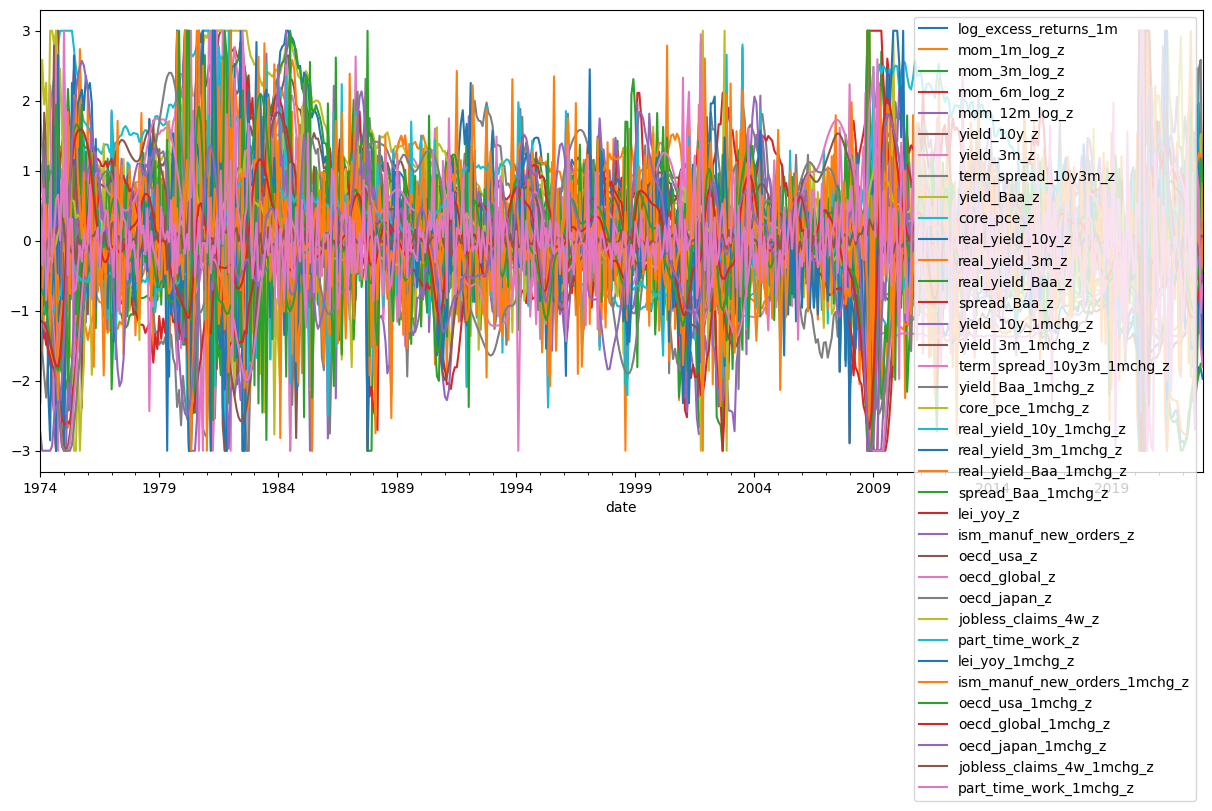

In [544]:
transformed_variables_df.plot(legend=True,figsize=(15,6))

In [545]:
#trend stationarity test for transformed predictors time series

transformed_adfuller_dict = {}
for variable in transformed_variables_df.columns:
    t_test_pred, p_value_pred = adfuller(transformed_variables_df[variable])[0:2]
    transformed_adfuller_dict[f'{variable}'] = [t_test_pred,p_value_pred]   

transformed_adfuller_df = pd.DataFrame(transformed_adfuller_dict)
transformed_adfuller_df = transformed_adfuller_df.transpose()
transformed_adfuller_df.columns = ['adf: test_statistic','adf: p_value']
transformed_adfuller_df['stationary 5% significance'] = np.where(transformed_adfuller_df['adf: p_value'] < 0.05, 'trend_stationary', 'trend_non_stationary!!!')
transformed_adfuller_df

,adf: test_statistic,adf: p_value,stationary 5% significance
log_excess_returns_1m,-10.405278,1.863801e-18,trend_stationary
mom_1m_log_z,-10.230995,5.029412e-18,trend_stationary
mom_3m_log_z,-6.077963,1.109783e-07,trend_stationary
mom_6m_log_z,-4.850414,4.351282e-05,trend_stationary
mom_12m_log_z,-4.598578,1.299513e-04,trend_stationary
yield_10y_z,-1.301842,6.283290e-01,trend_non_stationary!!!
yield_3m_z,-2.296836,1.729905e-01,trend_non_stationary!!!
term_spread_10y3m_z,-4.330933,3.925012e-04,trend_stationary
yield_Baa_z,-1.047185,7.356681e-01,trend_non_stationary!!!
core_pce_z,-2.374299,1.491221e-01,trend_non_stationary!!!


## 4. 1M-FORECASTING (no or very small auto-correlation)

### 3.1 IN-SAMPLE UNIVARIATE OLS REGRESSIONS: monthly
- Problem: are short-term monthly aggregate market returns forecastable? We know from dozens of academic papers that short-term index returns and excess-returns are very difficult to forecast as we have lots of white noise in the short run. It is not unusual to only find in-sample r-squared on predictive regressions (of monthly excess returns) of less than 5% and usually less than 1%. Out-of-sample predictive forecasts using recursive (expanding window: only using estimated coefficients up to time t and regressors known at time t) regressions often destroy any hope that was left from significant in-sample evidence. Academic evidence also shows that aggregate market returns might be somewhat forecastable if we (regress) forecast on longer time horizons. These regressions often suffer from serial correlation issues in the excess returns (response variable) so that significance might be wildly overstated. Hence, standard errors and hence t-stats (and p-values) are often corrected using Newey-West corrections (HAC-correction). 

- A recent paper gave some hope again on aggregate market short term forecasting using lagged independent variables claiming that C-mean (combined forecasts of uni-variate regressions: run uni-variate regressions seperatly and take the mean of all forecasts. This seems better than more complex multi-variate regression which quickly suffers from high-dimensionality problems in the face of lots of regressors.) It has been long known that forecasts can be improved by just taking lots of forecasts and then averaging them. 

- We hypothesize that monthly excess returns are not forecastable in-sample. The alternative is that they are to some extend.
    - H_0: beta = 0 <br>
    - H_A: beta >< 0 <br>
    First we run in-sample univariate regressions on all predictors.We check for first order correlation with Durbin Watson test.
    We check signs and significance of beta's.
    

- The in-sample univariate OLS uses the whole sample: this creates look-ahead bias.
- The in-sample univariate OLS uses standardized regressors. But the standardization also creates <br>
look-ahead bias as the z-score is calculated using the full sample (not on a rolling or expanding window)


for each variable: <br>

- Run a predictive in-sample regression on the lagged variables (z-scores, 1-month lagged)<br>

$$ r_{t} = C + \beta x_{t-1}+\epsilon_{t} $$

$$ r_{t} = \text{log excess return of month t}  $$
$$ x_{t-1} = \text{predictor value previous month t-1 = predictor lagged 1 month}  $$
$$ C_{t} = \text{Intercept coefficient estimated in sample}  $$
$$ \beta_{t} = \text{beta coefficient estimated in sample}  $$

As we have found a trend non-stationary process for some time-series we have gone back and made logs of them. We also used np.sqrt before z-scoring but non of these removed the non-stationary process. However, taking the absolute difference removes it, but we already use these difference series (1mchg). Hence, in our final in_sample we will drop following independent variables (and their z-scores): yield_10y, yield_3m, yield_Baa, core_pce, real_yield_10y, real_yield_3m, real_yield_Baa, part_time_work.

In [546]:
# Create in_sample_df_1m containing variables ready for use in regression

IN_SAMPLE_LAG = 1 # Regress excess return of the month on the lagged regressor value of the previous month (shift them up, + number, to align with response date)

# define the response variable: list of a series
in_sample_1m_response = log_excess_returns_1m

# define the predictors: list of series (drop the non-stationary ones)
in_sample_1m_predictors = [
    mom_1m_log_z, mom_3m_log_z, mom_6m_log_z, mom_12m_log_z,
    term_spread_10y3m_z,spread_Baa_z,
    yield_10y_1mchg_z, yield_3m_1mchg_z, term_spread_10y3m_1mchg_z, yield_Baa_1mchg_z, core_pce_1mchg_z, real_yield_10y_1mchg_z, real_yield_3m_1mchg_z, real_yield_Baa_1mchg_z, spread_Baa_1mchg_z,
    lei_yoy_z, ism_manuf_new_orders_z, oecd_usa_z, oecd_global_z, oecd_japan_z, jobless_claims_4w_z,
    lei_yoy_1mchg_z, ism_manuf_new_orders_1mchg_z, oecd_usa_1mchg_z, oecd_global_1mchg_z, oecd_japan_1mchg_z, jobless_claims_4w_1mchg_z, part_time_work_1mchg_z
    ]
    
# lag the predictors as we regress on lagged predictors
in_sample_1m_lagged_predictors = [in_sample_1m_predictor.shift(IN_SAMPLE_LAG).dropna() for in_sample_1m_predictor in in_sample_1m_predictors]

#final df
in_sample_df_1m = pd.concat(in_sample_1m_lagged_predictors,axis=1)
in_sample_df_1m.insert(0,'log_excess_returns_1m',in_sample_1m_response)
in_sample_df_1m.dropna(inplace = True)

In [547]:
in_sample_df_1m.head()

,log_excess_returns_1m,mom_1m_log_z,mom_3m_log_z,mom_6m_log_z,mom_12m_log_z,term_spread_10y3m_z,spread_Baa_z,yield_10y_1mchg_z,yield_3m_1mchg_z,term_spread_10y3m_1mchg_z,yield_Baa_1mchg_z,core_pce_1mchg_z,real_yield_10y_1mchg_z,real_yield_3m_1mchg_z,real_yield_Baa_1mchg_z,spread_Baa_1mchg_z,lei_yoy_z,ism_manuf_new_orders_z,oecd_usa_z,oecd_global_z,oecd_japan_z,jobless_claims_4w_z,lei_yoy_1mchg_z,ism_manuf_new_orders_1mchg_z,oecd_usa_1mchg_z,oecd_global_1mchg_z,oecd_japan_1mchg_z,jobless_claims_4w_1mchg_z,part_time_work_1mchg_z
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1974-02-28,-0.004386,-0.564619,-1.572200,-1.498727,-1.518824,-1.602932,-0.712177,0.311344,0.043307,0.214529,0.005872,1.493405,-0.441244,-0.507025,-1.038250,-0.340881,-1.067793,0.452509,0.508296,1.003254,1.803449,-0.280214,-2.320211,-1.571576,-0.679015,-1.141724,-2.723443,0.087724,0.544864
1974-03-31,-0.008254,-0.137154,-0.200857,-1.088105,-1.283200,-1.577735,-0.663750,0.033394,-0.045977,0.085952,0.232040,2.583411,-1.223348,-0.992453,-1.594987,0.129825,-1.239889,0.021476,0.357949,0.721964,1.322678,-0.221416,-0.957505,-0.833282,-0.704133,-1.158071,-3.000000,0.081579,-0.346003
1974-04-30,-0.030789,-0.219488,-0.521912,-1.269793,-1.263296,-1.930494,-1.039059,1.237843,1.828976,-1.071239,0.412975,1.946537,0.179070,1.021334,-0.992709,-1.046941,-1.394776,0.060661,0.184525,0.436125,0.778804,-0.240276,-0.860168,0.083220,-0.813735,-1.176983,-3.000000,-0.025958,0.738983
1974-05-31,-0.044100,-0.699139,-0.597855,-1.491567,-1.158477,-2.241258,-1.039059,0.774593,1.382559,-0.942662,1.136714,2.256732,-0.392040,0.483576,-0.567793,-0.004663,-1.394776,0.321893,-0.026057,0.132783,0.202977,-0.334575,0.015857,0.516013,-0.990207,-1.249746,-3.000000,-0.130423,-0.848632
1974-06-30,-0.016599,-0.982476,-1.075082,-0.877941,-1.310018,-1.670124,-0.651643,-0.429855,-1.831646,1.757449,0.820078,1.017968,-0.882592,-2.111932,0.012195,1.071238,-1.566872,0.112907,-0.284991,-0.194309,-0.349672,-0.324591,-0.957505,-0.400489,-1.219850,-1.348473,-3.000000,0.013984,-0.321738


In [548]:
in_sample_df_1m.shape

(586, 29)

<AxesSubplot: xlabel='date'>

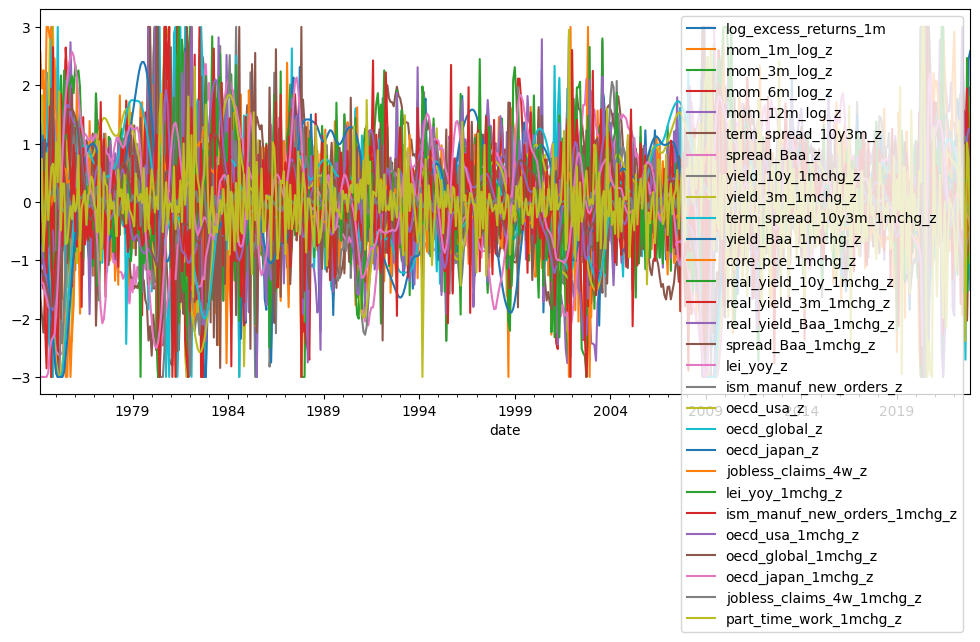

In [549]:
in_sample_df_1m[1:].plot(figsize=(12,5))

In [550]:
# Univariate in-sample regressions with response the 1-month excess return forecasts

in_sample_1m_forecast_summary=pd.DataFrame({},index=['intercept','beta','R2 %','t_stat','p_value','10%','5%','1%','Durbin-Watson <br> statistic'])

for col in in_sample_df_1m.columns[1:]:
    model=ols(f'log_excess_returns_1m ~ {col}',data=in_sample_df_1m).fit()
    model_stats=[model.params[0],model.params[1],model.rsquared*100,model.tvalues[1],model.pvalues[1],0,0,0,
                 durbin_watson(model.resid)]
    in_sample_1m_forecast_summary[col]=model_stats   
    
in_sample_1m_forecast_summary = in_sample_1m_forecast_summary.transpose()
in_sample_1m_forecast_summary['10%'] = np.where(in_sample_1m_forecast_summary.p_value < 0.1,'*','')
in_sample_1m_forecast_summary['5%'] = np.where(in_sample_1m_forecast_summary.p_value < 0.05,'**','')
in_sample_1m_forecast_summary['1%'] = np.where(in_sample_1m_forecast_summary.p_value < 0.01,'***','')

in_sample_1m_forecast_summary.index.name='regressors'
in_sample_1m_forecast_summary.style.set_caption("""
    In-sample, univariate predictive OLS on monthly US data (Feb/1974 - Nov/2022):<br>
    Response is the log excess return (equities - treasuries). Predictors are lagged 1 month. All predictors are <br>
    z-scores calculated on full sample. In-sample predictive OLS has look-ahead bias!   
    """)

,intercept,beta,R2 %,t_stat,p_value,10%,5%,1%,Durbin-Watson statistic
regressors,,,,,,,,,
mom_1m_log_z,0.002491,0.002272,0.212793,1.115959,0.264899,,,,1.981494
mom_3m_log_z,0.002473,0.002589,0.270985,1.259704,0.208279,,,,1.948668
mom_6m_log_z,0.002523,0.000572,0.013432,0.280098,0.779501,,,,1.901774
mom_12m_log_z,0.002520,0.001710,0.127144,0.862246,0.388906,,,,1.911585
term_spread_10y3m_z,0.002481,0.000354,0.005860,0.185002,0.853292,,,,1.891869
spread_Baa_z,0.001872,0.002831,0.256495,1.225473,0.220891,,,,1.885657
yield_10y_1mchg_z,0.002515,-0.002838,0.363036,-1.458716,0.145181,,,,1.873023
yield_3m_1mchg_z,0.002562,-0.004649,0.698315,-2.026534,0.043164,*,**,,1.861895
term_spread_10y3m_1mchg_z,0.002540,0.001977,0.154340,0.950126,0.342441,,,,1.888822


In [551]:
# Visual Look at regressors that seem to have some significance in short term forecasting (in-sample results)

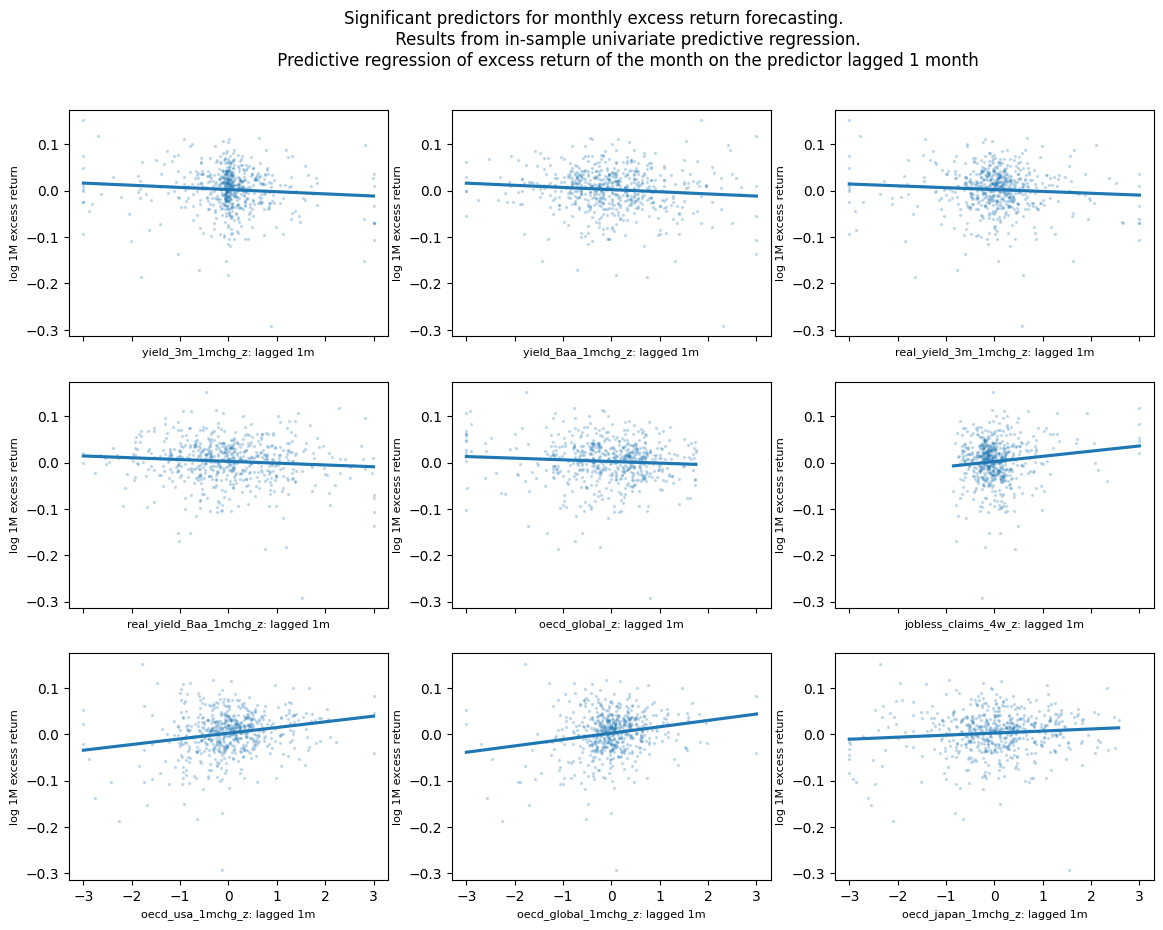

In [552]:
fig,ax = plt.subplots(3,3, figsize= (14,10), sharex=True)

fig.suptitle('''Significant predictors for monthly excess return forecasting.
             Results from in-sample univariate predictive regression.
             Predictive regression of excess return of the month on the predictor lagged 1 month''')

sns.regplot(ax = ax[0,0],x='yield_3m_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[0,0].set_xlabel("yield_3m_1mchg_z: lagged 1m",fontsize=8)
ax[0,0].set_ylabel("log 1M excess return",fontsize=8)


sns.regplot(ax = ax[0,1],x='yield_Baa_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[0,1].set_xlabel("yield_Baa_1mchg_z: lagged 1m",fontsize=8)
ax[0,1].set_ylabel("log 1M excess return",fontsize=8)

sns.regplot(ax = ax[0,2],x='real_yield_3m_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[0,2].set_xlabel("real_yield_3m_1mchg_z: lagged 1m",fontsize=8)
ax[0,2].set_ylabel("log 1M excess return",fontsize=8)

sns.regplot(ax = ax[1,0],x='real_yield_Baa_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[1,0].set_xlabel("real_yield_Baa_1mchg_z: lagged 1m",fontsize=8)
ax[1,0].set_ylabel("log 1M excess return",fontsize=8)

sns.regplot(ax = ax[1,1],x='oecd_global_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[1,1].set_xlabel("oecd_global_z: lagged 1m",fontsize=8)
ax[1,1].set_ylabel("log 1M excess return",fontsize=8)


sns.regplot(ax = ax[1,2],x='jobless_claims_4w_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[1,2].set_xlabel("jobless_claims_4w_z: lagged 1m",fontsize=8)
ax[1,2].set_ylabel("log 1M excess return",fontsize=8)

sns.regplot(ax = ax[2,0],x='oecd_usa_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[2,0].set_xlabel("oecd_usa_1mchg_z: lagged 1m",fontsize=8)
ax[2,0].set_ylabel("log 1M excess return",fontsize=8)

sns.regplot(ax = ax[2,1],x='oecd_global_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[2,1].set_xlabel("oecd_global_1mchg_z: lagged 1m",fontsize=8)
ax[2,1].set_ylabel("log 1M excess return",fontsize=8)

sns.regplot(ax = ax[2,2],x='oecd_japan_1mchg_z',y='log_excess_returns_1m',data = in_sample_df_1m,ci=None, scatter_kws={'s':2, 'alpha':0.2})
ax[2,2].set_xlabel("oecd_japan_1mchg_z: lagged 1m",fontsize=8)
ax[2,2].set_ylabel("log 1M excess return",fontsize=8)





plt.show()

### 3.2 OUT OF SAMPLE REGRESSIONS

In [553]:
all_oos_1m_predictors = [
    mom_1m_log_z_exp, mom_3m_log_z_exp, mom_6m_log_z_exp, mom_12m_log_z_exp,
    term_spread_10y3m_z_exp,spread_Baa_z_exp,
    yield_10y_1mchg_z_exp, yield_3m_1mchg_z_exp, term_spread_10y3m_1mchg_z_exp, yield_Baa_1mchg_z_exp, core_pce_1mchg_z_exp, real_yield_10y_1mchg_z_exp, real_yield_3m_1mchg_z_exp, real_yield_Baa_1mchg_z_exp, spread_Baa_1mchg_z_exp,
    lei_yoy_z_exp, ism_manuf_new_orders_z_exp, oecd_usa_z_exp, oecd_global_z_exp, oecd_japan_z_exp, jobless_claims_4w_z_exp,
    lei_yoy_1mchg_z_exp, ism_manuf_new_orders_1mchg_z_exp, oecd_usa_1mchg_z_exp, oecd_global_1mchg_z_exp, oecd_japan_1mchg_z_exp, jobless_claims_4w_1mchg_z_exp, part_time_work_1mchg_z_exp
    ]

In [554]:
# Create oos_df_1m_lag containing response and the lagged variables ready for use  in rolling oos predictive regressions, lagged variables are now the expanding z_scores

OOS_LAG = 1 # Regress excess return of the month on the lagged regressor value of the previous month (shift them up, + number, to align with response date)

# define the response variable: list of a series
oos_1m_response = log_excess_returns_1m

# define the predictors: list of series (drop the non-stationary ones)
oos_1m_predictors = [
    mom_1m_log_z_exp, mom_3m_log_z_exp, mom_6m_log_z_exp, mom_12m_log_z_exp,
    term_spread_10y3m_z_exp,spread_Baa_z_exp,
    yield_10y_1mchg_z_exp, yield_3m_1mchg_z_exp, term_spread_10y3m_1mchg_z_exp, yield_Baa_1mchg_z_exp, core_pce_1mchg_z_exp, real_yield_10y_1mchg_z_exp, real_yield_3m_1mchg_z_exp, real_yield_Baa_1mchg_z_exp, spread_Baa_1mchg_z_exp,
    lei_yoy_z_exp, ism_manuf_new_orders_z_exp, oecd_usa_z_exp, oecd_global_z_exp, oecd_japan_z_exp, jobless_claims_4w_z_exp,
    lei_yoy_1mchg_z_exp, ism_manuf_new_orders_1mchg_z_exp, oecd_usa_1mchg_z_exp, oecd_global_1mchg_z_exp, oecd_japan_1mchg_z_exp, jobless_claims_4w_1mchg_z_exp, part_time_work_1mchg_z_exp 
    ]
    
# lag the predictors as we regress on lagged predictors
oos_1m_lagged_predictors = [oos_1m_predictors.shift(OOS_LAG).dropna() for oos_1m_predictors in oos_1m_predictors]

#final df
oos_df_1m_lagged_predictors = pd.concat(oos_1m_lagged_predictors,axis=1)
oos_df_1m_lagged_predictors.insert(0,'log_excess_returns_1m',oos_1m_response)
oos_df_1m_lagged_predictors.dropna(inplace = True)

for each variable and for each time step t: <br>

- Run a predictive expanding regression on the lagged variables (expanding z_scores of the variables, warmed up n = 60 months) with a warm-up of n = 60 months of the form:<br>

$$ r_{t} = C_{t} + \beta_{t}x_{t-1}+\epsilon_{t} $$

$$ r_{t} = \text{log excess return of month t}  $$
$$ x_{t-1} = \text{predictor value previous month t-1 = predictor lagged 1 month}  $$
$$ C_{t} = \text{Constant coefficient estimated at month t}  $$
$$ \beta_{t} = \text{beta coefficient estimated at month t}  $$

- Each month - and for each predictor - we have estimated coefficients at month t that used all data from the warm-up date until month t. In contrast to in-sample predictive regressions our coefficients are now time-varying and are updated as new information becomes available. Expanding window regressions do not contain look-ahead bias as they only use information that was available for the investor at time t. Out z-scores are also adjusted for look-ahead bias as they are calculated on an expanding window as well. The downside of all this is that we have lost about 10 years of data (warm-up expanding z-score is 60 months and then we use a warm-up of 60 months again to warm-up our predictive regression)

- Since we have estimated coefficients for each month - and for each variable - we can now use the regression results and forecast the log excess return of next month (forecast for t+1 at month t) per predictor. Our forecast is:

$$ \hat r_{t+1} = \hat C_{t} + \hat \beta_{t}x_{t} $$



In [555]:
oos_df_1m_lagged_predictors.columns[1:]

Index(['mom_1m_log_z_exp', 'mom_3m_log_z_exp', 'mom_6m_log_z_exp',
       'mom_12m_log_z_exp', 'term_spread_10y3m_z_exp', 'spread_Baa_z_exp',
       'yield_10y_1mchg_z_exp', 'yield_3m_1mchg_z_exp',
       'term_spread_10y3m_1mchg_z_exp', 'yield_Baa_1mchg_z_exp',
       'core_pce_1mchg_z_exp', 'real_yield_10y_1mchg_z_exp',
       'real_yield_3m_1mchg_z_exp', 'real_yield_Baa_1mchg_z_exp',
       'spread_Baa_1mchg_z_exp', 'lei_yoy_z_exp', 'ism_manuf_new_orders_z_exp',
       'oecd_usa_z_exp', 'oecd_global_z_exp', 'oecd_japan_z_exp',
       'jobless_claims_4w_z_exp', 'lei_yoy_1mchg_z_exp',
       'ism_manuf_new_orders_1mchg_z_exp', 'oecd_usa_1mchg_z_exp',
       'oecd_global_1mchg_z_exp', 'oecd_japan_1mchg_z_exp',
       'jobless_claims_4w_1mchg_z_exp', 'part_time_work_1mchg_z_exp'],
      dtype='object')

In [556]:
# Run forecasts at time t for all predictors using the regression coefficients estimated at time t

oos_df_1m_forecasts = pd.DataFrame() #create empty df that will hold the forecasts (not lagged!) at time to for forecast t+1

for predictor in oos_df_1m_lagged_predictors.columns[1:]: #for each predictor we will forecast monthly
    
    endog = oos_df_1m_lagged_predictors['log_excess_returns_1m'] 
    exog = sm.add_constant(oos_df_1m_lagged_predictors[predictor]) 

    oos_model = RollingOLS(endog,exog, min_nobs = 60,
                           window = oos_df_1m_lagged_predictors.shape[0], expanding = True).fit()

    predictor_forecast_at_t = (oos_model.params['const'] + oos_model.params[predictor]*vars()[predictor]).dropna()
    oos_df_1m_forecasts[predictor] = predictor_forecast_at_t.dropna() #df holds all forecasts for all predictors at time t (no lag)

In [557]:
oos_df_1m_forecasts.shape

(468, 28)

In [558]:
oos_df_1m_forecasts.head()

,mom_1m_log_z_exp,mom_3m_log_z_exp,mom_6m_log_z_exp,mom_12m_log_z_exp,term_spread_10y3m_z_exp,spread_Baa_z_exp,yield_10y_1mchg_z_exp,yield_3m_1mchg_z_exp,term_spread_10y3m_1mchg_z_exp,yield_Baa_1mchg_z_exp,core_pce_1mchg_z_exp,real_yield_10y_1mchg_z_exp,real_yield_3m_1mchg_z_exp,real_yield_Baa_1mchg_z_exp,spread_Baa_1mchg_z_exp,lei_yoy_z_exp,ism_manuf_new_orders_z_exp,oecd_usa_z_exp,oecd_global_z_exp,oecd_japan_z_exp,jobless_claims_4w_z_exp,lei_yoy_1mchg_z_exp,ism_manuf_new_orders_1mchg_z_exp,oecd_usa_1mchg_z_exp,oecd_global_1mchg_z_exp,oecd_japan_1mchg_z_exp,jobless_claims_4w_1mchg_z_exp,part_time_work_1mchg_z_exp
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1983-12-31,0.001796,0.002179,0.000497,0.002443,0.008812,-0.000146,0.001224,0.002340,0.003095,-0.000696,0.001496,0.000025,0.001596,-0.005313,0.002907,-0.006101,-0.005687,0.003414,0.001416,0.003800,-0.004017,0.002488,0.002761,0.004718,0.006842,0.000405,0.011034,0.003627
1984-01-31,0.000064,0.001396,-0.000664,0.001947,0.007340,-0.000304,0.004055,0.002769,0.001344,0.008931,-0.000438,0.002202,0.001375,0.000188,0.001454,-0.008936,-0.009985,0.000731,0.000407,0.003111,-0.006612,0.001948,-0.001449,0.001882,0.004745,0.000827,0.008573,-0.001461
1984-02-29,-0.001759,-0.000422,-0.003694,0.001347,0.006568,-0.004403,-0.001672,0.000176,0.002135,0.006342,-0.003063,-0.005580,-0.002179,-0.007396,0.004600,-0.011500,-0.006779,-0.002260,-0.000855,0.002319,-0.009696,0.001222,0.009893,-0.000920,0.002490,0.001095,0.005118,0.001529
1984-03-31,0.003005,0.001023,-0.001078,0.001763,0.006512,-0.003704,-0.001141,-0.001339,0.000599,-0.012373,0.005594,0.001532,0.000367,0.001301,0.001631,-0.007945,-0.006048,-0.000319,-0.000032,0.002851,-0.006822,0.001742,0.000659,-0.003051,0.001194,0.002132,-0.000798,0.000539
1984-04-30,0.002176,0.001640,0.000021,0.002009,0.007584,-0.003396,-0.000201,0.002118,0.003492,-0.008471,0.005663,0.002449,0.004142,0.004828,0.001680,-0.005780,-0.003492,0.000355,0.000326,0.003094,-0.004639,0.002065,0.005262,-0.005629,-0.000155,0.002566,-0.006688,-0.002707


In [559]:
# calculate combined forecast of all regressions
c_mean_forecast_1m_at_t = oos_df_1m_forecasts.mean(axis=1)
c_mean_forecast_1m_at_t.name ='c_mean_forecast_1m_at_t'

In [560]:
#naive running mean forecast

naive_mean_forecast_1m_at_t = log_excess_returns_1m.expanding(60).apply(np.mean)
naive_mean_forecast_1m_at_t.name = 'naive_mean_forecast_at_t'

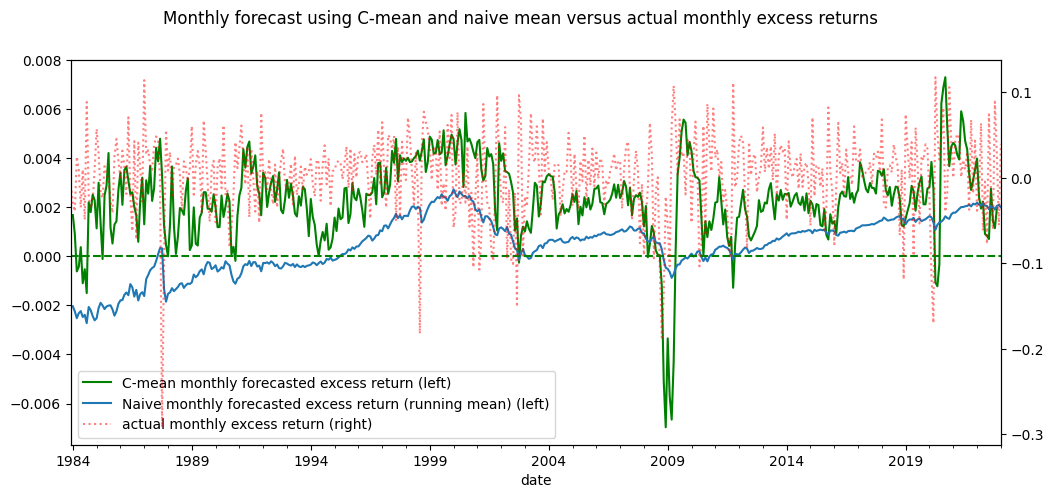

In [561]:
fig,ax =plt.subplots(figsize=(12,5))

fig.suptitle ('Monthly forecast using C-mean and naive mean versus actual monthly excess returns')
c_mean_forecast_1m_at_t['1983-12':].shift(1).plot(ax=ax,color = 'green', label = 'C-mean monthly forecasted excess return (left)',legend=True)
naive_mean_forecast_1m_at_t['1983-12':].shift(1).plot(ax=ax,label = 'Naive monthly forecasted excess return (running mean) (left)',legend=True )
log_excess_returns_1m['1983-12':].plot(secondary_y=True,alpha=0.5, linestyle=':',color = 'red', label = 'actual monthly excess return',legend=True)
ax.axhline(y=0,linestyle='--',color='green')

plt.show()


In [562]:
#calculate R-sqr out of sample for every predictor and then for the C-mean

LAG_FORECAST = 1

oos_1m_rsq_list = []
for predictor in oos_df_1m_forecasts.columns:
    msfe_predictor = np.sum((log_excess_returns_1m - oos_df_1m_forecasts[predictor].shift(LAG_FORECAST)).dropna()**2)
    msfe_mean = np.sum((log_excess_returns_1m - naive_mean_forecast_1m_at_t.shift(LAG_FORECAST)).dropna()**2)
    rsquared_oos_1m_predictor = 1-(msfe_predictor/msfe_mean)
    oos_1m_rsq_list.append(rsquared_oos_1m_predictor)





In [563]:
oos_1m_rsq_df = pd.DataFrame({
    'predictors':oos_df_1m_forecasts.columns,
    '$R^2_{oos}$':oos_1m_rsq_list
})

In [564]:
oos_1m_rsq_df

,predictors,$R^2_{oos}$
0,mom_1m_log_z_exp,0.102017
1,mom_3m_log_z_exp,0.099444
2,mom_6m_log_z_exp,0.098163
3,mom_12m_log_z_exp,0.097349
4,term_spread_10y3m_z_exp,0.101658
5,spread_Baa_z_exp,0.099528
6,yield_10y_1mchg_z_exp,0.103172
7,yield_3m_1mchg_z_exp,0.102432
8,term_spread_10y3m_1mchg_z_exp,0.102350
9,yield_Baa_1mchg_z_exp,0.100133


In [565]:
#single example
msfe_predictor = np.sum((log_excess_returns_1m - oos_df_1m_forecasts.oecd_usa_1mchg_z_exp.shift(1)).dropna()**2)
msfe_mean = np.sum((log_excess_returns_1m - naive_mean_forecast_1m_at_t.shift(1)).dropna()**2)
rs_sq = 1-(msfe_predictor/msfe_mean)

The out-of-sample r-squared seem strange compared to the original paper (however original paper has different horizons). Everything is close to 10%. I stopped here, did multiple checks on the code but could not find any distortion. Still, the results don't seem realistic. If anyone finds out why, please let me know. This is the disadvantage of being a lone coder versus working in team :-( 